# 挂载谷歌云盘便于文件保存

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# GPU版本开启cudnn

## 查看cudnn版本
需要对照官方兼容的版本

In [ ]:
#!nvcc --version
!grep CUDNN_MAJOR -A 2 /usr/include/cudnn_version.h


#define CUDNN_MAJOR 9
#define CUDNN_MINOR 2
#define CUDNN_PATCHLEVEL 1
--
#define CUDNN_VERSION (CUDNN_MAJOR * 10000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

/* cannot use constexpr here since this is a C-only file */


In [ ]:
!lsb_release -a


No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.4 LTS
Release:	22.04
Codename:	jammy


##重要提醒
下方代码运行时需要看到依赖都显示为YES
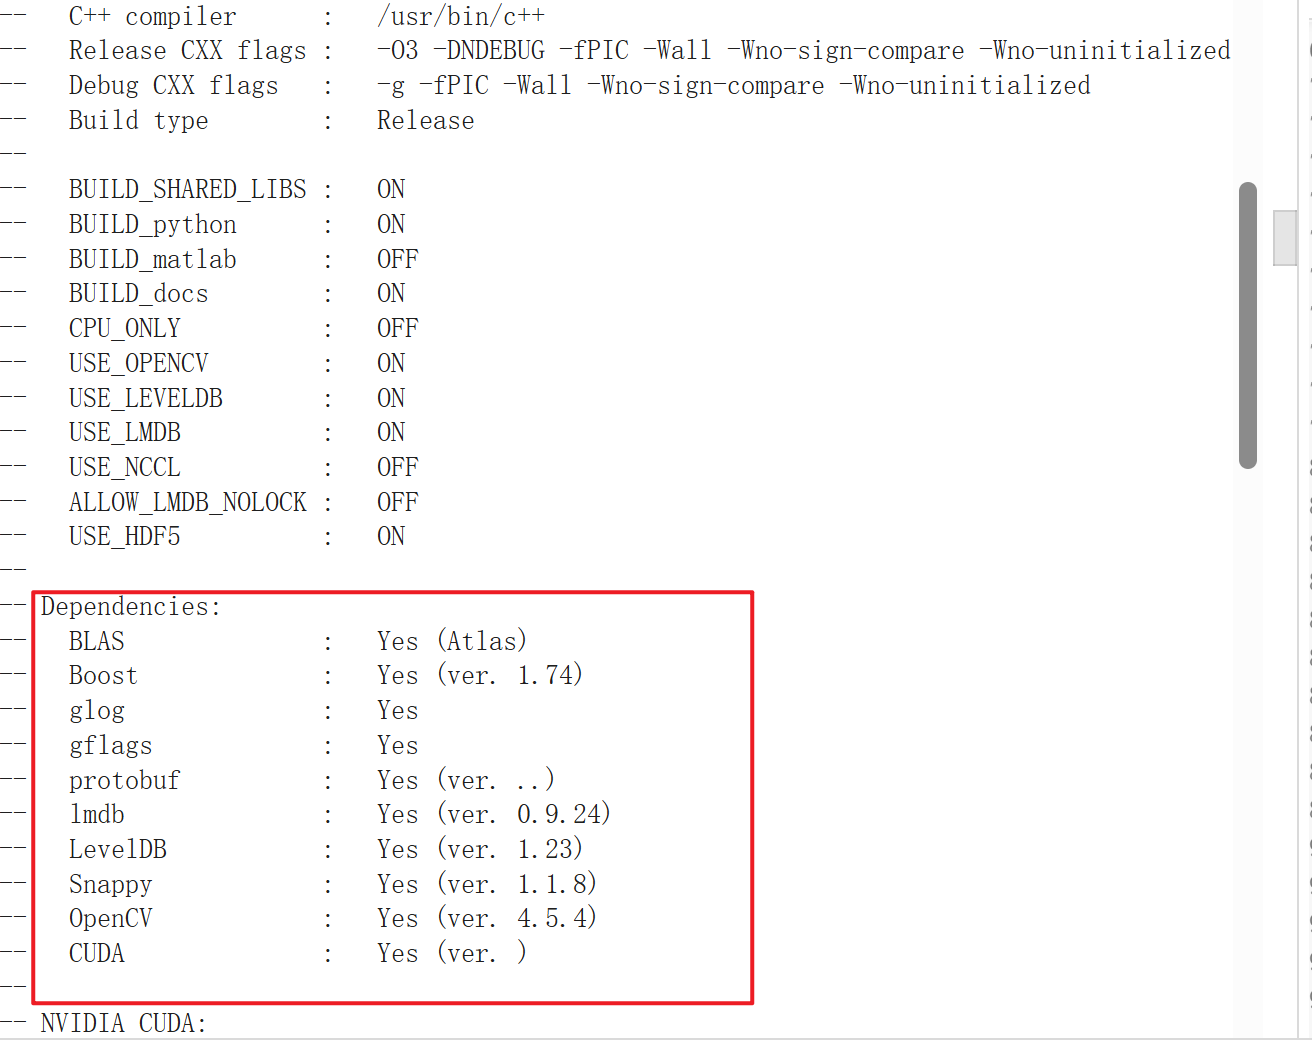

能识别到cuda12.5 cudnn*并且显示yes*

In [ ]:
import subprocess

bash_script = """#!/bin/bash

# ========= 用户配置区域 =========
CAFFE_ROOT=./caffe
BUILD_DIR=build
INSTALL_DIR=${CAFFE_ROOT}/install
PYTHON_VERSION=3.11
# =================================

echo "==> 安装依赖..."
apt update
apt install -y \\
    build-essential \\
    cmake \\
    git \\
    libprotobuf-dev \\
    libleveldb-dev \\
    libsnappy-dev \\
    libopencv-dev \\
    libhdf5-serial-dev \\
    protobuf-compiler \\
    libgflags-dev \\
    libgoogle-glog-dev \\
    liblmdb-dev \\
    libboost-all-dev \\
    libopenblas-dev \\
    python${PYTHON_VERSION}-dev \\
    python3-pip

echo "==> 克隆 Caffe..."
git clone -b cudnn9.6 https://github.com/dyc2424748461/caffe.git ${CAFFE_ROOT}
cd ${CAFFE_ROOT}

echo "==> 安装 Python 依赖..."
cd python
#pip3 install -r requirements.txt
cd ..

echo "==> 创建构建目录..."
mkdir -p ${BUILD_DIR}
cd ${BUILD_DIR}

echo "==> 执行 CMake 配置（cudnn）..."
cmake .. \\
    -DUSE_CUDNN=ON \\
    -DCUDA_ARCH_NAME=Manual \\
    -DUSE_CUDA_FOR_SOME_FILES=ON \\
    -DUSE_CUDA_FOR_SELECTED_FILES=ON \\
    -DCUDA_NVCC_FLAGS="-std=c++17 --expt-relaxed-constexpr" \\
    #-DCUDNN_LIBRARY=/usr/lib/x86_64-linux-gnu/libcudnn.so \\
    -DCMAKE_INSTALL_RPATH='$ORIGIN/../lib' \\
    -DCUDA_TOOLKIT_ROOT_DIR=/usr/local/cuda-12.5 \\
    -DCUDA_ARCH_BIN="60 70 75 80 86"
echo "==> 开始编译..."
make -j$(nproc)

echo "==> 可选安装到 ${INSTALL_DIR}..."
#make install

echo "==> 添加 PYTHONPATH..."
export PYTHONPATH=${CAFFE_ROOT}/python:$PYTHONPATH

echo "✅ 编译完成（cudnn版本）"
"""

# 写入并运行脚本
with open("build_caffe_gpu.sh", "w") as f:
    f.write(bash_script)

!chmod +x build_caffe_gpu.sh

# 实时输出日志
with subprocess.Popen(['bash', 'build_caffe_gpu.sh'], stdout=subprocess.PIPE, stderr=subprocess.STDOUT, bufsize=1, universal_newlines=True) as proc:
    for line in proc.stdout:
        print(line, end='')

==> 安装依赖...


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,844 kB]
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy/main amd64 Packages [46.3 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/

In [ ]:
!rm -r /caffe/build

In [ ]:
!cd caffe/build/ && make install

[  1%] Built target caffeproto
[  1%] Building CUDA object src/caffe/CMakeFiles/caffe.dir/util/math_functions.cu.o
In file included from /content/caffe/src/caffe/util/math_functions.cu:7:
/usr/local/cuda/targets/x86_64-linux/include/math_functions.h:54:2: warning: #warning "math_functions.h is an internal header file and must not be used directly.  This file will be removed in a future CUDA release.  Please use cuda_runtime_api.h or cuda_runtime.h instead." []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wcpp-Wcpp]8;;]
   54 | #warning "math_functions.h is an internal header file and must not be used directly.  This file will be removed in a future CUDA release.  Please use cuda_runtime_api.h or cuda_runtime.h instead."
      |  ^~~~~~~
In file included from /content/caffe/src/caffe/util/math_functions.cu:7:
/usr/local/cuda/targets/x86_64-linux/include/math_functions.h:54:2: warning: #warning "math_functions.h is an internal header file and must not be used direc

编译完成后，即可打包。移动到相似的环境中使用即可，不用再次编译

In [ ]:
!apt install patchelf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  patchelf
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 72.1 kB of archives.
After this operation, 186 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 patchelf amd64 0.14.3-1 [72.1 kB]
Fetched 72.1 kB in 0s (260 kB/s)
Selecting previously unselected package patchelf.
(Reading database ... 127688 files and directories currently installed.)
Preparing to unpack .../patchelf_0.14.3-1_amd64.deb ...
Unpacking patchelf (0.14.3-1) ...
Setting up patchelf (0.14.3-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
%%writefile package_caffe.sh
#!/bin/bash

# Author: 专为Caffe环境一键打包而设计
# Function: 自动收集依赖，生成自包含的Caffe部署包

set -e
set -u

# 配置区
OUTDIR="caffe_package"
BUILD_DIR="build"
BIN_DIR="${BUILD_DIR}/tools"
LIB_DIR="${BUILD_DIR}/lib"
EXTRA_MODEL_DIR="models"  # 如果有模型可选地拷贝进来

echo "[+] Starting Caffe packaging process..."

# 0. 清理旧目录
rm -rf ${OUTDIR}
mkdir -p ${OUTDIR}/{bin,lib,models,scripts}

# 1. 拷贝可执行文件
echo "[+] Copying binaries..."
find ${BIN_DIR} -type f -perm /111 -exec cp -v {} ${OUTDIR}/bin/ \;

# 2. 拷贝Caffe自己的动态库
echo "[+] Copying Caffe libraries..."
cp -v ${LIB_DIR}/*.so* ${OUTDIR}/lib/

# 3. 自动分析并拷贝所有依赖动态库
echo "[+] Scanning and copying runtime dependencies..."

echo "[+] Scanning and copying runtime dependencies..."

for binfile in ${OUTDIR}/bin/*; do
    if file "$binfile" | grep -q "ELF"; then
        echo "    Analyzing dependencies for $binfile ..."
        ldd "$binfile" | grep "=>" | while read -r line; do
            dep=$(echo "$line" | awk '{print $(NF-1)}')
            if [ -f "$dep" ]; then
                echo "        Found dependency $dep"
                cp -u "$dep" ${OUTDIR}/lib/
            fi
        done
    fi
done


# 遍历lib目录下所有.so文件（有的.so内部也有依赖）
for sofile in ${OUTDIR}/lib/*.so*; do
    if file "$sofile" | grep -q "ELF"; then
        echo "    Analyzing dependencies for $sofile ..."
        if timeout 5s ldd "$sofile" > /tmp/ldd_output.txt; then
            cat /tmp/ldd_output.txt | grep "=>" | grep -v "not found" | awk '{print $(NF-1)}' | grep "^/" | while read -r dep; do
                if [ -f "$dep" ]; then
                    src="$dep"
                    dst="${OUTDIR}/lib/$(basename "$dep")"
                    if [ "$(realpath "$src")" != "$(realpath "$dst")" ]; then
                        echo "        Copying dependency $src"
                        cp -u "$src" "$dst"
                    else
                        echo "        [Info] Dependency already exists, skip copying: $src"
                    fi
                else
                    echo "        [Warning] Dependency not found: $dep"
                fi
            done
        else
            echo "    [Timeout] Skipping $sofile due to slow dependency analysis."
        fi
    fi
done


# 4. 拷贝额外文件（模型）
if [ -d "${EXTRA_MODEL_DIR}" ]; then
    echo "[+] Copying models..."
    cp -rv ${EXTRA_MODEL_DIR}/* ${OUTDIR}/models/ || true
fi

# 5. 修改可执行文件和动态库的RPATH（高级部署）
echo "[+] Fixing RPATHs with patchelf..."

for target in ${OUTDIR}/bin/*; do
    if file "$target" | grep -q "ELF"; then
        patchelf --set-rpath '$ORIGIN/../lib' "$target"
    fi
done

for target in ${OUTDIR}/lib/*.so*; do
    if file "$target" | grep -q "ELF"; then
        patchelf --set-rpath '$ORIGIN' "$target"
    fi
done

# 6. 创建运行脚本
echo "[+] Creating launcher script..."
cat <<EOF2 > ${OUTDIR}/scripts/run_caffe.sh
#!/bin/bash
export LD_LIBRARY_PATH=\$(dirname "\$0")/../lib:\$LD_LIBRARY_PATH
\$(dirname "\$0")/../bin/caffe "\$@"
EOF2
chmod +x ${OUTDIR}/scripts/run_caffe.sh

# 7. 打包成压缩包
echo "[+] Creating compressed archive..."
tar -czvf caffe_package.tar.gz ${OUTDIR}

echo "[✔] Packaging completed successfully! Output: caffe_package.tar.gz"

Overwriting package_caffe.sh


In [ ]:
!cp package_caffe.sh caffe/

In [ ]:
!cd caffe/ && bash package_caffe.sh

[+] Starting Caffe packaging process...
[+] Copying binaries...
'build/tools/upgrade_net_proto_text-d' -> 'caffe_package/bin/upgrade_net_proto_text-d'
'build/tools/extract_features-d' -> 'caffe_package/bin/extract_features-d'
'build/tools/upgrade_solver_proto_text-d' -> 'caffe_package/bin/upgrade_solver_proto_text-d'
'build/tools/compute_image_mean-d' -> 'caffe_package/bin/compute_image_mean-d'
'build/tools/upgrade_net_proto_binary-d' -> 'caffe_package/bin/upgrade_net_proto_binary-d'
'build/tools/caffe-d' -> 'caffe_package/bin/caffe-d'
'build/tools/convert_imageset-d' -> 'caffe_package/bin/convert_imageset-d'
[+] Copying Caffe libraries...
'build/lib/_caffe-d.so' -> 'caffe_package/lib/_caffe-d.so'
'build/lib/libcaffe-d.so' -> 'caffe_package/lib/libcaffe-d.so'
'build/lib/libcaffe-d.so.1.0.0' -> 'caffe_package/lib/libcaffe-d.so.1.0.0'
[+] Scanning and copying runtime dependencies...
[+] Scanning and copying runtime dependencies...
    Analyzing dependencies for caffe_package/bin/caffe-d 

In [ ]:
!cp caffe/caffe_package.tar.gz drive/MyDrive/caffe/

如何在另一个相似环境中使用
1. 导入压缩包并解压
2. 使用脚本scripts/run_caffe.sh 即可

# 测试

In [ ]:
%cd /content/caffe/caffe_package/

In [ ]:
!cd models/bvlc_alexnet/ && wget http://dl.caffe.berkeleyvision.org/bvlc_reference_caffenet.caffemodel

In [ ]:
!./scripts/run_caffe.sh time --model models/bvlc_reference_caffenet/deploy.prototxt --weights models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel --iterations 10 --gpu 0
